# Imports

In [54]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random as rd
from scipy import stats
from mpl_toolkits.mplot3d import Axes3D
import sklearn.metrics
from sklearn.model_selection import KFold

# Setting random seed
random_seed = 1234

# Opening Datasets

Uploading Datasets From Local Files

In [ ]:
# Import NHANES and Breast Cancer Wisonsin Datasets from your computer
from google.colab import files
uploaded = files.upload()

Saving NHANES_age_prediction.csv to NHANES_age_prediction.csv
Saving breast-cancer-wisconsin.data to breast-cancer-wisconsin.data


# Data Pre-Processing



Opening Datasets in Pandas

In [ ]:
age_dataset = pd.read_csv('NHANES_age_prediction.csv')
cancer_dataset = pd.read_csv('breast-cancer-wisconsin.data', names=['Sample Code Number','Clump Thickness','Uniformity of Cell Size','Uniformity of Cell Shape','Marginal Adhesion','Simple Epithelial Cell Size','Bare Nuclei','Bland Chromatin','Normal Nucleoli','Mitoses','Class'])

Removing Points With Missing Attribute Values

In [ ]:
cancer_dataset = cancer_dataset[cancer_dataset != '?']
cancer_dataset = cancer_dataset.dropna().reset_index(drop=True)
age_dataset = age_dataset.dropna().reset_index(drop=True)

Seperating Into Input and Output Points

In [ ]:
X_age = age_dataset.loc[:,["RIAGENDR","PAQ605","BMXBMI","LBXGLU","DIQ010","LBXGLT","LBXIN"]]
Y_age = age_dataset.loc[:,["age_group"]]
X_cancer = cancer_dataset.loc[:,['Clump Thickness','Uniformity of Cell Size','Uniformity of Cell Shape','Marginal Adhesion','Simple Epithelial Cell Size','Bare Nuclei','Bland Chromatin','Normal Nucleoli','Mitoses']]
Y_cancer = cancer_dataset.loc[:,['Class']]

Converting Input Attributes to Floats

In [ ]:
X_age = X_age.astype(float)
X_cancer = X_cancer.astype(float)

Input Data Standardization

In [ ]:
def standardize(x_data):
  """
  Function: Standardizes the attributes (input space) using a z-score
  Args:
  - x_data: Input attributes
  Returns:
  - x_norm: Normalized input attributes
  """

  x_norm = stats.zscore(x_data)

  return x_norm

X_age = standardize(X_age)
X_cancer = standardize(X_cancer)

Output Data Binary Classification Standardization

In [ ]:
Y_cancer = Y_cancer.replace(2,0).replace(4,1)
Y_cancer.rename(columns={'Class':'Cancer Diagnosis'}, inplace=True)
Y_age = Y_age.replace('Adult',0).replace('Senior',1)
Y_age.rename(columns={'age_group':'Age Group'}, inplace=True)

# Data Visualization and Statistics

Percentages of Population and Random Chance

In [ ]:
def percentages(y_labels):

  # The Type of Label Associated With Dataset
  label = y_labels.columns[0]

  # Total length of Dataset
  total_population = len(y_labels)

  # Number of Seniors and Adults in Sample
  negative_count = np.sum((y_labels[label] == 0))
  positive_count = np.sum((y_labels[label] == 1))

  # Respective Percentages of Adults ad
  negative_percentage = negative_count/total_population
  positive_percentage = positive_count/total_population

  return [negative_count,positive_count, negative_percentage, positive_percentage]

Output Label Distribution

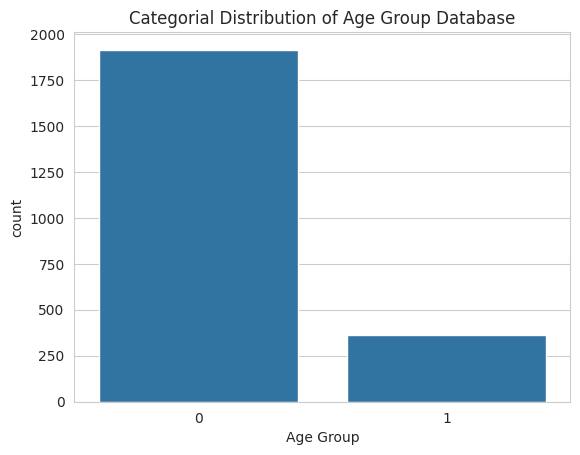

Total population of Age Group Database: 2278
# of Negatives: 1914 - 84.02 % of Sample.
# of Seniors: 364 - 15.98 % of Sample.


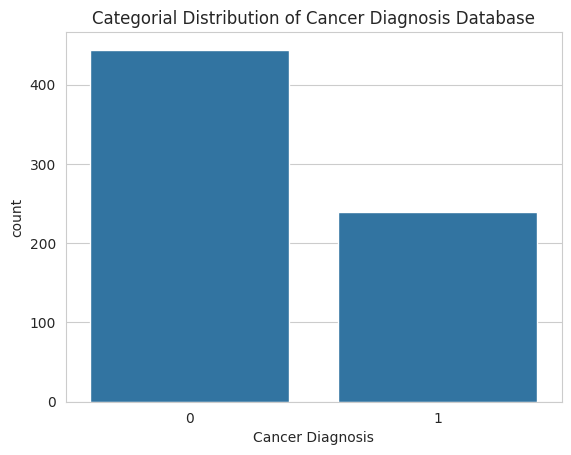

Total population of Cancer Diagnosis Database: 683
# of Negatives: 444 - 65.01 % of Sample.
# of Seniors: 239 - 34.99 % of Sample.


In [ ]:
def label_distribution(y_labels):
  """
  Function: Creates a histogram plot showing the frequencies of each type of
  category within the dataset
  Args:
  - y_labels(pd dataframe): The labels of the data points within the dataset
  Returns: None
  """

  # The Type of Label Associated With Dataset
  label = y_labels.columns[0]

  # Seaborn Style
  sns.set_style("whitegrid")

  # Categorial Histograph
  hist = sns.countplot(y_labels, x=label)
  hist.set(title="Categorial Distribution of " + label + " Database", xlabel=y_labels.columns)
  plt.show()

  per = percentages(y_labels)

  print('Total population of',label,'Database:', per[0]+per[1])
  print('# of Negatives:', per[0],'-', round(per[2]*100,2),'% of Sample.')
  print('# of Seniors:', per[1],'-', round(per[3]*100,2),'% of Sample.')

random_chance_age = label_distribution(Y_age)
random_chance_cancer = label_distribution(Y_cancer)


Visualizing the Input Space - Colouring Points by Their Labels

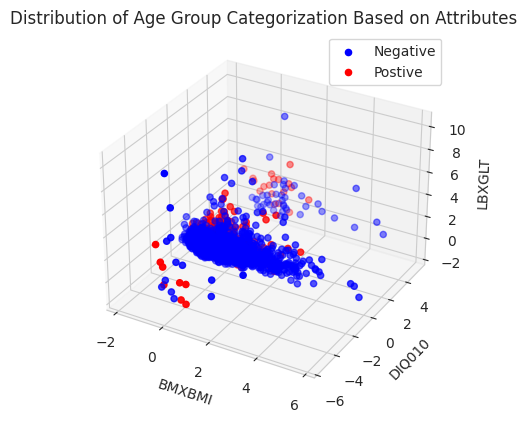

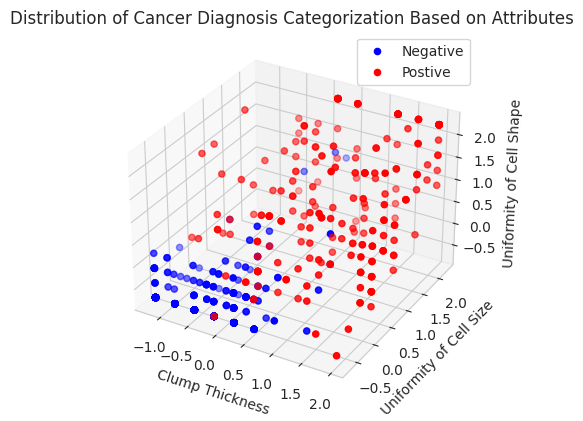

In [ ]:
def attribute_3D_grid(x_data, y_labels, attributes):
  """
  Function: Creates a 3D subset of the input space (the 3 attributes shown can
  be chosen by the user), with their label being shown in colour
  Args:
  - dataframe(pd dataframe): The dataset being analyzed
  - attributes(list): Attributes included within the graph (must have 3)
  Returns: None
  """

  # The Type of Label Associated With Dataset
  label_type = y_labels.columns[0]

  # Combine Input Data and Output Labels as Singular PD Dataframe
  dataframe = pd.concat([x_data,y_labels], axis=1)

  # Extracts attributes data and their respective labels from dataset
  plotted_data = np.array(dataframe.loc[:,[label_type,attributes[0], attributes[1], attributes[2]]])

  # Setting up and labeling the 3D scatter plot
  fig = plt.figure()
  ax = plt.axes(projection='3d')
  ax.set_title('Distribution of '+ label_type +' Categorization Based on Attributes')
  ax.set_xlabel(attributes[0])
  ax.set_ylabel(attributes[1])
  ax.set_zlabel(attributes[2])

  # Seperating the points by categorization
  negative_data = plotted_data[(plotted_data[:,0] == 0.),1:]
  positive_data = plotted_data[(plotted_data[:,0] == 1.),1:]

  # Plotting the points by categorization
  ax.scatter(negative_data[:,0],negative_data[:,1],negative_data[:,2], color='blue',label='Negative')
  ax.scatter(positive_data[:,0],positive_data[:,1],positive_data[:,2], color='red',label='Postive')

  # Displaying legend
  ax.legend()

attribute_3D_grid(X_age,Y_age,['BMXBMI',	'DIQ010',	'LBXGLT'])
attribute_3D_grid(X_cancer,Y_cancer,['Clump Thickness','Uniformity of Cell Size','Uniformity of Cell Shape'])

Comparison of the Mean of the Positive and Negative Groups (For Feature Selection)

In [ ]:
def compare_attributes_mean(x_data,y_labels):
  """
  Function: Find the squared difference between the means of the positive and negative group
  Args:
  - x_data: The input attributes
  - y_data: The output labels
  Returns: None
  """

  # Seperating x_data by label
  x_data_negative = x_data[np.array(y_labels.iloc[:]) == [0]].reset_index(inplace=False)
  x_data_positive = x_data[np.array(y_labels.iloc[:]) == [1]].reset_index(inplace=False)

  # Finding the mean of each attribute (column)
  negative_mean = x_data_negative.mean()
  positive_mean = x_data_positive.mean()

  # Finding squared difference of the mean
  squared_difference = pd.DataFrame(((negative_mean - positive_mean)**2)[1:], columns=['Squared Difference'])

  # Sorting the squared difference in increasing order
  squared_difference = squared_difference.sort_values(by=['Squared Difference'])

  print(squared_difference)

In [ ]:
compare_attributes_mean(X_age,Y_age)

          Squared Difference
RIAGENDR            0.000057
BMXBMI              0.000128
DIQ010              0.005191
LBXIN               0.030661
PAQ605              0.066923
LBXGLU              0.101025
LBXGLT              0.440230


In [ ]:
compare_attributes_mean(X_cancer,Y_cancer)

                             Squared Difference
Mitoses                                0.788244
Simple Epithelial Cell Size            2.098766
Marginal Adhesion                      2.192965
Clump Thickness                        2.246039
Normal Nucleoli                        2.270535
Bland Chromatin                        2.527317
Uniformity of Cell Size                2.961671
Uniformity of Cell Shape               2.969538
Bare Nuclei                            2.975358


# Simple Test/Train Data Splitting

Test-Train Split for KNN (Returns Pandas Dataframes)

In [ ]:
def test_train_split_KNN(x_data,y_data,split_percentage,seed):
  """
  Function: Seperates dataset into randomized subsets (training and test data)
  according to a specific pseudorandom seed and a proportion
  Args:
  - x_data(pd df): The input attributes
  - y_data(pd df): The labels associated with a set of attributes
  - split_percentage(int): The proportion of the training and test sets
  - seed(int): The pseudorandom seed of the randomization
  Returns:
  - x_train(pd df): The randomized training attributes
  - x_test(pd df): The randomized testing attributes
  - y_train(pd df): The randmized training labels
  - y_test(pd df): The randomized testing labels
  """

  # Setting a specific pseudorandom seed
  np.random.seed(seed)

  # For now, setting the test set to the whole data set
  x_test = x_data
  y_test = y_data
  # For now, making an empty set for the training set
  x_train = pd.DataFrame()
  y_train = pd.DataFrame()

  # Loop will pick a random point from test set and place it into training set
  # Then remove that point from the test set
  for i in range(int(split_percentage*len(x_data)/100)):

    # A random pick that serves as the index of the test set
    rd_pick = np.random.randint(0,len(x_test))

    # The random pick from the test set
    x_entry = pd.DataFrame.transpose(pd.DataFrame(x_test.iloc[rd_pick,:]))
    y_entry = pd.DataFrame.transpose(pd.DataFrame(y_test.iloc[rd_pick,:]))

    # Adding this random point to the training set
    x_train = pd.concat([x_train, x_entry],axis=0)
    y_train = pd.concat([y_train, y_entry],axis=0)

    # Removing this random point from the test set
    x_test = x_test.drop([rd_pick],axis=0).reset_index(drop=True)
    y_test = y_test.drop([rd_pick],axis=0).reset_index(drop=True)

  # Returning the split training and test sets
  return x_train, x_test, y_train, y_test

# Sample Function Call
#x_train_KNN, x_test_KNN, y_train_KNN, y_test_KNN = test_train_split_KNN(X_age,Y_age,50,random_seed)

Test-Train Split for DTs (Returns np arrays)

In [ ]:
def test_train_split_DT(x_data,y_data,split_percentage,seed):
  """
  Function: Seperates dataset into randomized subsets (training and test data)
  according to a specific pseudorandom seed and a proportion
  Args:
  - x_data(pd df): The input attributes
  - y_data(pd df): The labels associated with a set of attributes
  - split_percentage(int): The proportion of the training and test sets
  - seed(int): The pseudorandom seed of the randomization
  Returns:
  - x_train(np array): The randomized training attributes
  - x_test(np array): The randomized testing attributes
  - y_train(np array): The randmized training labels
  - y_test(pd df): The randomized testing labels
  """

  # Setting a specific pseudorandom seed
  np.random.seed(seed)

  # For now, setting the test set to the whole data set
  x_test = x_data
  y_test = y_data
  # For now, making an empty set for the training set
  x_train = pd.DataFrame()
  y_train = np.zeros(int(split_percentage*len(x_data)/100))

  # Loop will pick a random point from test set and place it into training set
  # Then remove that point from the test set
  for i in range(int(split_percentage*len(x_data)/100)):

    # A random pick that serves as the index of the test set
    rd_pick = np.random.randint(0,len(x_test))

    # The random pick from the test set
    x_entry = pd.DataFrame.transpose(pd.DataFrame(x_test.iloc[rd_pick,:]))
    y_entry = pd.DataFrame.transpose(pd.DataFrame(y_test.iloc[rd_pick,:]))

    # Adding this random point to the training set
    x_train = pd.concat([x_train, x_entry],axis=0)
    y_train[i] = np.array(y_entry)[0][0]

    # Removing this random point from the test set
    x_test = x_test.drop([rd_pick],axis=0).reset_index(drop=True)
    y_test = y_test.drop([rd_pick],axis=0).reset_index(drop=True)

  # Returning the split training and test sets
  return np.array(x_train), np.array(x_test), y_train.astype(int), y_test

# Sample Function Call
x_train_DT, x_test_DT, y_train_DT, y_test_DT = test_train_split_DT(X_age,Y_age,50,random_seed)

# Simple Test-Train-Validation Data Splitting

For KNNs (Returns PD Dataframes)

In [57]:
def test_train_validation_KNN(x_data,y_data,split_percentages,seed):
  """
  Function: Seperates dataset into randomized subsets (training and test data)
  according to a specific pseudorandom seed and a proportion
  Args:
  - x_data(pd df): The input attributes
  - y_data(pd df): The labels associated with a set of attributes
  - split_percentage(list): The proportion of the training,validation and test sets (in that order)
  - seed(int): The pseudorandom seed of the randomization
  Returns:
  - x_train(pd df): The randomized training attributes
  - x_test(pd df): The randomized testing attributes
  - x_val(np array): The randomized validation attributes
  - y_train(pd df): The randmized training labels
  - y_test(pd df): The randomized testing labels
  - y_val(pd df): The randomized validation labels
  """

  # Setting a specific pseudorandom seed
  np.random.seed(seed)

  # For now, setting the test set to the whole data set
  x_test = x_data
  y_test = y_data
  # For now, making an empty set for the training set
  x_train = pd.DataFrame()
  y_train = pd.DataFrame()
  # For now, making an empty set for the validation set
  x_val = pd.DataFrame()
  y_val = pd.DataFrame()

  # Loop will pick a random point from test set and place it into training set
  # Then remove that point from the test set
  for i in range(int(split_percentages[0]*len(x_data)/100)):

    # A random pick that serves as the index of the test set
    rd_pick = np.random.randint(0,len(x_test))

    # The random pick from the test set
    x_entry = pd.DataFrame.transpose(pd.DataFrame(x_test.iloc[rd_pick,:]))
    y_entry = pd.DataFrame.transpose(pd.DataFrame(y_test.iloc[rd_pick,:]))

    # Adding this random point to the training set
    x_train = pd.concat([x_train, x_entry],axis=0)
    y_train = pd.concat([y_train, y_entry],axis=0)

    # Removing this random point from the test set
    x_test = x_test.drop([rd_pick],axis=0).reset_index(drop=True)
    y_test = y_test.drop([rd_pick],axis=0).reset_index(drop=True)

  for j in range(int(split_percentages[1]*len(x_data)/100)):

    # A random pick that serves as the index of the test set
    rd_pick = np.random.randint(0,len(x_test))

    # The random pick from the test set
    x_entry = pd.DataFrame.transpose(pd.DataFrame(x_test.iloc[rd_pick,:]))
    y_entry = pd.DataFrame.transpose(pd.DataFrame(y_test.iloc[rd_pick,:]))

    # Adding this random point to the training set
    x_val = pd.concat([x_val, x_entry],axis=0)
    y_val = pd.concat([y_val, y_entry],axis=0)

    # Removing this random point from the test set
    x_test = x_test.drop([rd_pick],axis=0).reset_index(drop=True)
    y_test = y_test.drop([rd_pick],axis=0).reset_index(drop=True)

  # Returning the split training and test sets
  return x_train, x_test, y_train, y_test, x_val, y_val

# Sample Function Call
#x_train_KNN, x_test_KNN, y_train_KNN, y_test_KNN, x_val_KNN, y_val_KNN = test_train_validation_KNN(X_age,Y_age,[50,25,25],random_seed)

For DTs (Returns x_train as an np array)

In [ ]:
def test_train_validation_DT(x_data,y_data,split_percentages,seed):
  """
  Function: Seperates dataset into randomized subsets (training and test data)
  according to a specific pseudorandom seed and a proportion
  Args:
  - x_data(pd df): The input attributes
  - y_data(pd df): The labels associated with a set of attributes
  - split_percentage(list): The proportion of the training,validation and test sets (in that order)
  - seed(int): The pseudorandom seed of the randomization
  Returns:
  - x_train(np array): The randomized training attributes
  - x_test(np array): The randomized testing attributes
  - x_val(np array): The randomized validation attributes
  - y_train(np array): The randmized training labels
  - y_test(pd df): The randomized testing labels
  - y_val(pd df): The randomized validation labels
  """

  # Setting a specific pseudorandom seed
  np.random.seed(seed)

  # For now, setting the test set to the whole data set
  x_test = x_data
  y_test = y_data
  # For now, making an empty set for the training set
  x_train = pd.DataFrame()
  y_train = np.zeros(int(split_percentages[0]*len(x_data)/100))
  # For now, making an empty set for the validation set
  x_val = pd.DataFrame()
  y_val = pd.DataFrame()

  # Loop will pick a random point from test set and place it into training set
  # Then remove that point from the test set
  for i in range(int(split_percentages[0]*len(x_data)/100)):

    # A random pick that serves as the index of the test set
    rd_pick = np.random.randint(0,len(x_test))

    # The random pick from the test set
    x_entry = pd.DataFrame.transpose(pd.DataFrame(x_test.iloc[rd_pick,:]))
    y_entry = pd.DataFrame.transpose(pd.DataFrame(y_test.iloc[rd_pick,:]))

    # Adding this random point to the training set
    x_train = pd.concat([x_train, x_entry],axis=0)
    y_train[i] = np.array(y_entry)[0][0]

    # Removing this random point from the test set
    x_test = x_test.drop([rd_pick],axis=0).reset_index(drop=True)
    y_test = y_test.drop([rd_pick],axis=0).reset_index(drop=True)

  for j in range(int(split_percentages[1]*len(x_data)/100)):

    # A random pick that serves as the index of the test set
    rd_pick = np.random.randint(0,len(x_test))

    # The random pick from the test set
    x_entry = pd.DataFrame.transpose(pd.DataFrame(x_test.iloc[rd_pick,:]))
    y_entry = pd.DataFrame.transpose(pd.DataFrame(y_test.iloc[rd_pick,:]))

    # Adding this random point to the training set
    x_val = pd.concat([x_val, x_entry],axis=0)
    y_val = pd.concat([y_val, y_entry],axis=0)

    # Removing this random point from the test set
    x_test = x_test.drop([rd_pick],axis=0).reset_index(drop=True)
    y_test = y_test.drop([rd_pick],axis=0).reset_index(drop=True)

  # Returning the split training and test sets
  return np.array(x_train), np.array(x_test), np.array(x_val,astype(float)), y_train.astype(int), y_test, y_val

# Sample Function Call
#x_train_DT, x_test_DT, x_val_DT, y_train_DT, y_test_DT, y_val_DT = test_train_validation_DT(X_age,Y_age,[50,25,25],random_seed)

# Splitting for K-fold cross validation

In [ ]:
def k_fold_split_np_copy(x_data, y_data, k, seed):
    """
    Function: Splits dataset into k folds using KFold cross-validation
    Args:
    - x_data(pd df): The input attributes
    - y_data(pd df): The labels associated with a set of attributes
    - k(int): Number of folds
    - seed(int): The pseudorandom seed for reproducibility
    Returns:
    - List of tuples, each containing (x_train_np, x_test_np, y_train_np, y_test_np) for a fold
    """
    # Setting a specific pseudorandom seed
    np.random.seed(seed)

    # Initializing KFold object
    kf = KFold(n_splits=k, shuffle=True, random_state=seed)

    # List to store the results for each fold
    folds = []

    # Creating folds using KFold
    for train_index, test_index in kf.split(x_data):
        x_train, x_test = x_data.iloc[train_index], x_data.iloc[test_index]
        y_train, y_test = y_data.iloc[train_index], y_data.iloc[test_index]

        # Convert to NumPy arrays
        x_train_np = np.array(x_train)
        x_test_np = np.array(x_test)

        y_train_np = np.zeros(len(y_train), dtype=int)
        y_test_np = np.zeros(len(y_test), dtype=int)

        for i in range(len(y_train_np)):
            y_train_np[i] = np.array(y_train)[i]

        for j in range(len(y_test_np)):
            y_test_np[j] = np.array(y_test)[j]

        folds.append((x_train_np, x_test_np, y_train_np, y_test_np))

    return folds

# Example usage:
folds_np_copy = k_fold_split_np_copy(X_age, Y_age, 5, random_seed)
#folds_np_copy = k_fold_split_np_copy(X_cancer, Y_cancer, 5, random_seed)



# Basic Metrics Functions

Prediction - Calculating TP, TN, FP and FN

In [ ]:
def count_classifications(y_pred,y_test):
  """
  Function: Count the true positive, true negatives, false positives, false negatives
  Args:
  - y_pred(pd df): Predicted labels given by model
  - y_test(pd df): Actual labels tested against
  Returns:
  - TP: True Positive Count
  - TN: True Negative Count
  - FP: False Positive Count
  - FN: False Negative Count
  """

  # Convering to np arrays for convenience
  y_pred = np.array(y_pred)
  y_test = np.array(y_test)

  # Making sure the dimensions match before comparing
  if len(y_pred) == len(y_test):

    # Setting initial count of zero
    TP = 0
    TN = 0
    FP = 0
    FN = 0

    # Loop checks every point with one another
    for i in range(len(y_pred)):

      # True Negative
      if y_pred[i][0] == 0 and y_test[i][0] == 0:

        TN += 1

      # True Positive
      elif y_pred[i][0] == 1 and y_test[i][0] == 1:

        TP += 1

      # False Positive
      elif y_pred[i][0] == 1 and y_test[i][0] == 0:

        FP += 1

      # False Negative
      elif y_pred[i][0] == 0 and y_test[i][0] == 1:

        FN += 1

  else:

    raise ValueError('Dimensions of dataframes do not match')

  return TP, TN, FP, FN

Accuracy Metric

In [ ]:
def accuracy(y_pred,y_test):

  TP, TN, FP, FN = count_classifications(y_pred,y_test)

  return (TP+TN)/(TP+TN+FP+FN)

Precision Metric

In [ ]:
def precision(y_pred,y_test):

  TP, TN, FP, FN = count_classifications(y_pred,y_test)

  if TP == 0:

    return 0

  else:

    return TP/(TP+FP)

Recall Metric

In [ ]:
def recall(y_pred,y_test):

  TP, TN, FP, FN = count_classifications(y_pred,y_test)

  if TP == 0:

    return 0

  else:

    return TP/(TP+FN)

False Negative Rate

In [ ]:
def false_positive_rate(y_pred,y_test):

  TP, TN, FP, FN = count_classifications(y_pred,y_test)

  if FP == 0:

    return 0

  else:

    return FP/(FP+TN)

# K-Nearest Neighbors Algorithm





Similarity Functions

In [ ]:
def euclidean_distance(x1,x2):

  component_distance = np.subtract(x1,x2)

  return np.linalg.norm(component_distance)

def cosine_similarity(x1,x2):

  dot = np.dot(x1,x2)
  norm = np.linalg.norm(x1)*np.linalg.norm(x2)

  return dot/norm

Normal KNN Algorithm

In [ ]:
def k_nearest_neighbors(x_train, y_train, x_test, k, threshold, similarity_type='euclid'):
  """
  Function: KNN algorithm will search for points within the training set that
  are the most similar to a point in the test set. Then, it will pick its label.
  Args:
  - x_train(pd df): The training attributes
  - y_train(pd df): The training labels
  - x_test(pd df): The test attributes
  - k(int): The number of nearest neighbours searched
  - threshold(float): Probability threshold needed for positive diagnosis
  - similarity_type(str): Type of similarity metric used between test and train points
  Returns:
  - y_pred(pd df): The predicted labels of the test attributes
  """

  # Converting pd dataframes into np arrays for convenience
  x_test = np.array(x_test)
  x_train = np.array(x_train)
  y_train = np.array(y_train)

  # Creating an empty pd dataframe for the predicted labels
  y_pred = pd.DataFrame()

  # Loop will find the nearest neighbours for all test points
  for i in range(len(x_test)):

    # A specific point within the test set
    x_i = x_test[i]

    # Empty list for the distances between all points within the training set
    xi_similarities = []

    # Loop will calculate the distances between xi all points in the training set
    for j in range(len(x_train)):

      # A specific point within the training set
      x_j = x_train[j]

      # Norm of distance vector
      if similarity_type == 'euclid':

        similarity = euclidean_distance(x_i,x_j)

      elif similarity_type == 'cosine':

        similarity = cosine_similarity(x_i,x_j)

      # Adding norm of distance vector to distances list
      xi_similarities.append(similarity)

    # Empty dictionary containing the probability of each label for a point xi
    prob_dict = {}

    # Loop will find k nearest neighbours
    for s in range(k):

      # The index of the minimum distance in the distances list
      min_index = np.argmin(xi_similarities)

      # The label of this minimum distance
      min_label = y_train[min_index][0]

      # If the label is in the dictionary already, add another fraction of its
      # probability
      if min_label in prob_dict:

        prob_dict[min_label] += 1/k

      # If it is not in dictionary, add it and set its probability to 1/k
      elif min_label not in prob_dict:

        prob_dict[min_label] = 1/k

      # Removing the minimum distance from the the distances list
      del xi_similarities[min_index]

    # If there are no instances of the positive class in the dictionary, then
    # its prob value is 0
    if prob_dict.get(1) == None:

      prob_dict[1] = 0.0

    # The predicted label is the label with the highest probability
    #prediction = pd.DataFrame([list(prob_dict.keys())[np.argmax(list(prob_dict.values()))]])

    # The predicted label is based on the probability threshold
    if prob_dict.get(1) > threshold:

      prediction = pd.DataFrame([1])

    elif prob_dict.get(1) <= threshold:

      prediction = pd.DataFrame([0])

    # Adding the prediction for the point xi to the pd dataframe
    y_pred = pd.concat([y_pred,prediction])

  # Returning the predicted labels
  return y_pred.reset_index(drop=True)

# Sample Function Call
#x_train_KNN, x_test_KNN, y_train_KNN, y_test_KNN = test_train_split_KNN(X_age,Y_age,50,random_seed)
#y_pred = k_nearest_neighbors(x_train_KNN,y_train_KNN,x_test_KNN,1,0.5)

Weighted KNN Algorithm

In [ ]:
def weighted_k_nearest_neighbors(x_train, y_train, x_test, k, threshold, similarity_type='euclid'):
  """
  Function: KNN algorithm will search for points within the training set that
  are the most similar to a point in the test set, with a bias for those with
  the most similarity according to a specific metric. Then, it will pick its label.
  Args:
  - x_train(pd df): The training attributes
  - y_train(pd df): The training labels
  - x_test(pd df): The test attributes
  - k(int): The number of nearest neighbours searched
  - threshold(float): Probability threshold needed for positive diagnosis
  - similarity_type(str): Type of similarity metric used between test and train points
  Returns:
  - y_pred(pd df): The predicted labels of the test attributes
  """

  # Converting pd dataframes into np arrays for convenience
  x_test = np.array(x_test)
  x_train = np.array(x_train)
  y_train = np.array(y_train)

  # Creating an empty pd dataframe for the predicted labels
  y_pred = pd.DataFrame()

  # Loop will find the nearest neighbours for all test points
  for i in range(len(x_test)):

    # A specific point within the test set
    x_i = x_test[i]

    # Empty list for the distances between all points within the training set
    xi_similarities = []

    # Loop will calculate the distances between xi all points in the training set
    for j in range(len(x_train)):

      # A specific point within the training set
      x_j = x_train[j]

      # Norm of distance vector
      if similarity_type == 'euclid':

        dist = euclidean_distance(x_i,x_j)

        if dist != 0:

          similarity = dist

        else:

          similarity = 1

      elif similarity_type == 'cosine':

        # Normalizing cosine similarity
        dist = (cosine_similarity(x_i,x_j) + 1)/2

        if dist != 0:

          similarity = dist

        else:

          similarity = 1


      # Adding norm of distance vector to distances list
      xi_similarities.append(similarity)

    # Empty dictionary containing the probability of each label for a point xi
    prob_dict = {}

    total_similarity = 0

    # Loop will find k nearest neighbours
    for s in range(k):

      # The index of the minimum distance in the distances list
      min_index = np.argmin(xi_similarities)

      # The label of this minimum distance
      min_label = y_train[min_index][0]

      # If the label is in the dictionary already, add another fraction of its
      # probability
      if min_label in prob_dict:

        prob_dict[min_label] += 1/xi_similarities[min_label]
        total_similarity += 1/xi_similarities[min_label]

      # If it is not in dictionary, add it and set its probability to 1/k
      elif min_label not in prob_dict:

        prob_dict[min_label] = 1/xi_similarities[min_label]
        total_similarity += 1/xi_similarities[min_label]

      # Removing the minimum distance from the the distances list
      del xi_similarities[min_index]

    # Normalizing Probability if Distance Isn't Zero
    if total_similarity != 0:
      for i in prob_dict:

        prob_dict[i] = prob_dict[i]/total_similarity

    # If there are no instances of the positive class in the dictionary, then
    # its prob value is 0
    if prob_dict.get(1) == None:

      prob_dict[1] = 0.0

    # The predicted label is the label with the highest probability
    #prediction = pd.DataFrame([list(prob_dict.keys())[np.argmax(list(prob_dict.values()))]])

    # The predicted label is based on the probability threshold
    if prob_dict.get(1) > threshold:

      prediction = pd.DataFrame([1])

    elif prob_dict.get(1) <= threshold:

      prediction = pd.DataFrame([0])

    # Adding the prediction for the point xi to the pd dataframe
    y_pred = pd.concat([y_pred,prediction])

  # Returning the predicted labels
  return y_pred.reset_index(drop=True)

# Sample Function Call
#x_train_KNN, x_test_KNN, y_train_KNN, y_test_KNN = test_train_split_KNN(X_age,Y_age,50,random_seed)
#y_pred = weighted_k_nearest_neighbors(x_train_KNN,y_train_KNN,x_test_KNN,3,0.5,similarity_type='cosine')

# Evaluating KNN Algorithm

Hyperparameter Selection Using Train-Test-Valiation (Normal KNN)

In [58]:
def k_hyperparameter(x_train, x_val, y_train, y_val, k_values_to_try, thresholds_to_try, similarity,weighted=False):
  """
  Function: Checks over different combinations of k and thresholds to find the best combination (with highest
  validation accuracy)
  Args:
  - x_train(pd df): The randomized training attributes
  - x_val(pd df): The randomized validation attributes
  - y_train(pd df): The randmized training labels
  - y_val(pd df): The randomized validation labels
  - k_values_to_try(list): All k values tried in loop
  - thresholds_to_try(list): Probability (Activation) thresholds tried in loop
  - similarity: distance/cost function used in KNN
  Returns: None
  """

  # Setting max metric data to zero
  max_accuracy = [0,0,0]
  max_precision = [0,0,0]
  max_recall = [0,0,0]

  # Empty np arrays to be filled in during loop, used for plotting
  accuracy_array = np.zeros((len(thresholds_to_try),len(k_values_to_try)))
  precision_array = np.zeros((len(thresholds_to_try),len(k_values_to_try)))
  recall_array = np.zeros((len(thresholds_to_try),len(k_values_to_try)))

  # Tries different probability thresholds
  for prob in range(len(thresholds_to_try)):

    # Tries different k values
    for k in range(len(k_values_to_try)):

      # The predicted labels based on validation set
      if weighted:

        y_pred_val = weighted_k_nearest_neighbors(x_train,y_train,x_val,k_values_to_try[k],thresholds_to_try[prob],similarity_type=similarity)

      else:

        y_pred_val = k_nearest_neighbors(x_train,y_train,x_val,k_values_to_try[k],thresholds_to_try[prob],similarity_type=similarity)

      # Validation metrics
      accuracy_val = accuracy(y_pred_val,y_val)
      precision_val = precision(y_pred_val,y_val)
      recall_val = recall(y_pred_val,y_val)

      # If metrics are higher than the max metrics so far, they become the new max
      if accuracy_val >= max_accuracy[0]:

        max_accuracy = [accuracy_val,k_values_to_try[k],thresholds_to_try[prob]]

      if precision_val >= max_precision[0]:

        max_precision = [precision_val,k_values_to_try[k],thresholds_to_try[prob]]

      if recall_val >= max_recall[0]:

        max_recall = [recall_val,k_values_to_try[k],thresholds_to_try[prob]]

      # Adding the metrics to the empty np arrays for plotting
      accuracy_array[prob,k] = accuracy_val
      precision_array[prob,k] = precision_val
      recall_array[prob,k] = recall_val

  # Creating the plots using nested loop
  for metric in ['Accuracy','Precision','Recall']:

    for prob in range(len(thresholds_to_try)):

      if metric == 'Accuracy':

        plot_data = accuracy_array[prob]

      if metric == 'Precision':

        plot_data = precision_array[prob]

      if metric == 'Recall':

        plot_data = recall_array[prob]

      """
      plt.plot(k_values_to_try, plot_data,label=thresholds_to_try[prob])
      plt.xlabel('k')
      plt.ylabel(metric)
      plt.title(metric+' Over K ('+similarity+')')

    if metric == 'Accuracy':
      random_chance = percentages(pd.concat([y_train,y_val]))
      plt.axhline(y=random_chance[2], color='k', linestyle='--',label='Always Guessing Negative')

    plt.legend()
    plt.show()
    """

  print('Max Accuracy, Best k, Best Threshold: ', max_accuracy)
  print('Max Precision, Best k, Best Threshold: ', max_precision)
  print('Max Recall, Best k, Best Threshold: ', max_recall)

In [ ]:
x_train_KNN, x_test_KNN, y_train_KNN, y_test_KNN, x_val_KNN, y_val_KNN = test_train_validation_KNN(X_age,Y_age,[50,25,25],random_seed)

In [59]:
# Normal KNN - Eulidean Distance on Age Dataset
k_hyperparameter(x_train_KNN, x_val_KNN, y_train_KNN, y_val_KNN, [1,2,3,4,8,12,15,18,25,50],[0.3,0.5,0.7,0.9],'euclid')

Max Accuracy, Best k, Best Threshold:  [0.8330404217926186, 8, 0.5]
Max Precision, Best k, Best Threshold:  [1.0, 15, 0.5]
Max Recall, Best k, Best Threshold:  [0.5360824742268041, 3, 0.3]


In [ ]:
# Normal KNN - Cosine Similarity on Age Dataset
k_hyperparameter(x_train_KNN, x_val_KNN, y_train_KNN, y_val_KNN, [1,2,3,4,8,12,15,18,25,50],[0.3,0.5,0.7,0.9],'cosine')

In [ ]:
# Weighted KNN - Eulidean Distance on Age Dataset
k_hyperparameter(x_train_KNN, x_val_KNN, y_train_KNN, y_val_KNN, [1,2,3,4,8,12,15,18,25,50],[0.3,0.5,0.7,0.9],'euclid',weighted=True)

In [ ]:
# Weighted KNN - Cosine Similarity on Age Dataset
k_hyperparameter(x_train_KNN, x_val_KNN, y_train_KNN, y_val_KNN, [1,2,3,4,8,12,15,18,25,50],[0.3,0.5,0.7,0.9],'euclid',weighted=True)

In [ ]:
x_train_KNN, x_test_KNN, y_train_KNN, y_test_KNN, x_val_KNN, y_val_KNN = test_train_validation_KNN(X_cancer,Y_cancer,[50,25,25],random_seed)

In [ ]:
# Normal KNN - Eulidean Distance on Cancer Dataset
k_hyperparameter(x_train_KNN, x_val_KNN, y_train_KNN, y_val_KNN, [1,2,3,4,8,12,15,18,25,50],[0.3,0.5,0.7,0.9],'euclid')

In [ ]:
# Normal KNN - Cosine Similarity on Cancer Dataset
k_hyperparameter(x_train_KNN, x_val_KNN, y_train_KNN, y_val_KNN, [1,2,3,4,8,12,15,18,25,50],[0.3,0.5,0.7,0.9],'cosine')

In [ ]:
# Weighted KNN - Eulidean Distance on Cancer Dataset
k_hyperparameter(x_train_KNN, x_val_KNN, y_train_KNN, y_val_KNN, [1,2,3,4,8,12,15,18,25,50],[0.3,0.5,0.7,0.9],'euclid',weighted=True)

In [ ]:
# Weighted KNN - Cosine Similarity on Cancer Dataset
k_hyperparameter(x_train_KNN, x_val_KNN, y_train_KNN, y_val_KNN, [1,2,3,4,8,12,15,18,25,50],[0.3,0.5,0.7,0.9],'euclid',weighted=True)

Testing Best Hyperparameter (Best K) on Test Data

In [62]:
def model_evaluation_KNN(x_train,x_test,y_train,y_test,best_k,best_prob,similarity,weighted=False):
  """
  Function: Using the optimized hyperparameter values on the test set
  Args:
  - x_train(pd df): The randomized training attributes
  - x_test(pd df): The randomized test attributes
  - y_train(pd df): The randmized training labels
  - y_test(pd df): The randomized testing labels
  - best_k(int): Optimized k value
  - best_prob(float): Optimized threshold value
  - similarity(str): distance/cost function used in KNN
  Returns: None
  """

  # Predicted labels of test set
  if weighted:

    y_pred = weighted_k_nearest_neighbors(x_train,y_train,x_test,best_k,best_prob,similarity_type=similarity)
  else:

    y_pred = k_nearest_neighbors(x_train,y_train,x_test,best_k,best_prob,similarity_type=similarity)

  # Testing metrics
  accuracy_test = accuracy(y_pred,y_test)
  precison_test = precision(y_pred,y_test)
  recall_test = recall(y_pred,y_test)

  # Confusion Matrix
  cm = sklearn.metrics.confusion_matrix(y_test,y_pred)
  disp = sklearn.metrics.ConfusionMatrixDisplay(confusion_matrix=cm)
  disp.plot()

  print('The accuracy is: ', accuracy_test)
  print('The precision is: ', precison_test)
  print('The recall is: ', recall_test)

In [ ]:
x_train_KNN, x_test_KNN, y_train_KNN, y_test_KNN, x_val_KNN, y_val_KNN = test_train_validation_KNN(X_age,Y_age,[50,25,25],random_seed)

In [ ]:
# Best model for the Age Dataset
model_evaluation_KNN(x_train_KNN,x_val_KNN,y_train_KNN,y_val_KNN,8,0.5,'euclid')

In [ ]:
x_train_KNN, x_test_KNN, y_train_KNN, y_test_KNN, x_val_KNN, y_val_KNN = test_train_validation_KNN(X_cancer,Y_cancer,[50,25,25],random_seed)

In [ ]:
# Best Model for the Cancer Dataset
model_evaluation_KNN(x_train_KNN,x_val_KNN,y_train_KNN,y_val_KNN,18,0.3,'euclid',weighted=True)

AUROC

In [ ]:
def auroc(x_train,x_test,y_train,y_test,best_k,similarity,print_plot=True):
  """
  Function: Returns the AUROC score of model with the ROC graph
  Args:
  - x_train(pd df): The randomized training attributes
  - x_test(pd df): The randomized test attributes
  - y_train(pd df): The randmized training labels
  - y_test(pd df): The randomized testing labels
  - best_k(int): Optimized k value
  - similarity(str): Distance/cost function of KNN
  - print_plot(bool): Show ROC plot or not
  Returns:
  - auc: The AUROC score of model
  """

  # Empty lists for plotting the ROC
  TPR_list = []
  FPR_list = []

  # Tests various thresholds for ROC
  for prob in [1,0.7,0.5,0.1,-1]:

    # Predicted labels based on training data
    y_pred = weighted_k_nearest_neighbors(x_train,y_train,x_test,best_k,prob,similarity_type=similarity)

    # True and False Positive Rate
    TPR = recall(y_pred,y_test)
    FPR = false_positive_rate(y_pred,y_test)

    # Adding to lists for plotting
    TPR_list.append(TPR)
    FPR_list.append(FPR)

  # Plotting the ROC
  if print_plot:
    plt.plot(FPR_list,TPR_list)
    plt.title('Receiver Operating Characteristic')
    plt.xlabel('False Positive Rate')
    plt.ylabel("True Positive Rate")
    plt.xlim(0.)
    plt.ylim(0.)
    plt.fill_between(FPR_list,TPR_list,alpha=0.1)
    plt.show()

  # AUROC Metric
  auc = sklearn.metrics.auc(FPR_list,TPR_list)

  return auc

# Sample Function Call
#x_train_KNN, x_test_KNN, y_train_KNN, y_test_KNN = test_train_split_KNN(X_age,Y_age,80,random_seed)
#auroc(x_train_KNN, x_test_KNN, y_train_KNN, y_test_KNN, 1,'euclid')

How k Affects Training and Testing Accuracy With Best Model

In [61]:
def acc_over_k(x_train,y_train,x_test,y_test,k_values_to_try):
  """
  Function: Plotting the effect of k on the testing and training accuracy, AUROC metric
  Args:
  - x_train(pd df): The randomized training attributes
  - x_test(pd df): The randomized test attributes
  - y_train(pd df): The randmized training labels
  - y_test(pd df): The randomized testing labels
  - k_values_to_try(list): k values to test
  Returns: None
  """

  # Empty lists for plotting
  auroc_list = []
  train_acc_list = []
  test_acc_list = []

  # Tries different k values
  for k in k_values_to_try:

    # Labels based on training and testing sets
    y_pred_train = k_nearest_neighbors(x_train,y_train,x_train,k,0.5)
    y_pred_test = k_nearest_neighbors(x_train,y_train,x_test,k,0.5)

    # AUROC metric based on testing set
    auc = auroc(x_train, x_test, y_train, y_test, k,'euclid',print_plot=False)

    # Testing and training acccuracy
    train_acc = accuracy(y_pred_train,y_train)
    test_acc = accuracy(y_pred_test,y_test)

    # Adding metrics to empty lists for plotting
    auroc_list.append(auc)
    train_acc_list.append(train_acc)
    test_acc_list.append(test_acc)

  # Plotting
  plt.plot(k_values_to_try, auroc_list, label='AUROC')
  plt.plot(k_values_to_try, train_acc_list, label='Training Accuracy')
  plt.plot(k_values_to_try, test_acc_list, label='Testing Accuracy')
  random_chance = percentages(pd.concat([y_train,y_test]))
  plt.axhline(y=random_chance[2], color='k', linestyle='--',label='Always Guessing Negative')
  plt.legend()
  plt.xlabel('k')
  plt.ylabel('Normalized Metric')
  plt.show()

In [ ]:
x_train_KNN, x_test_KNN, y_train_KNN, y_test_KNN = test_train_split_KNN(X_age,Y_age,80,random_seed)

In [ ]:
acc_over_k(x_train_KNN, y_train_KNN, x_test_KNN, y_test_KNN, [1,12,24,36,48])

In [ ]:
x_train_KNN, x_test_KNN, y_train_KNN, y_test_KNN = test_train_split_KNN(X_cancer,Y_cancer,80,random_seed)

In [ ]:
acc_over_k(x_train_KNN, y_train_KNN, x_test_KNN, y_test_KNN, [1,12,24,36,48])

# Decision Tree Algorithm


Creating Node Class with Constructor to Initialize Nodes as Objects



In [67]:
class Node:
    def __init__(self, data_indices, parent):
        self.data_indices = data_indices                    #stores the data indices which are in the region defined by this node
        self.left = None                                    #stores the left child of the node
        self.right = None                                   #stores the right child of the node
        self.split_feature = None                           #the feature for split at this node
        self.split_value = None                             #the value of the feature for split at this node
        if parent:
            self.depth = parent.depth + 1                   #obtain the dept of the node by adding one to dept of the parent
            self.num_classes = parent.num_classes           #copies the num classes from the parent
            self.data = parent.data                         #copies the data from the parent
            self.labels = parent.labels                     #copies the labels from the parent
            class_prob = np.bincount(self.labels[data_indices], minlength=self.num_classes) #this is counting frequency of different labels in the region defined by this node
            self.class_prob = class_prob / np.sum(class_prob)  #stores the class probability for the node
            #note that we'll use the class probabilites of the leaf nodes for making predictions after the tree is built

Greedy Heuristics Algorithm

In [68]:
def greedy_test(node, cost_fn):
    #initialize the best parameter values
    best_cost = np.inf
    best_feature, best_value = None, None
    num_instances, num_features = node.data.shape
    #sort the features to get the test value candidates by taking the average of consecutive sorted feature values
    data_sorted = np.sort(node.data[node.data_indices],axis=0)
    test_candidates = (data_sorted[1:] + data_sorted[:-1]) / 2.
    for f in range(num_features):
        #stores the data corresponding to the f-th feature
        data_f = node.data[node.data_indices, f] ##this is the threshold value for splitting nodes
        for test in test_candidates[:,f]:
            #Split the indices using the test value of f-th feature
            left_indices = node.data_indices[data_f <= test]
            right_indices = node.data_indices[data_f > test]
            #we can't have a split where a child has zero element
            #if this is true over all the test features and their test values  then the function returns the best cost as infinity
            if len(left_indices) == 0 or len(right_indices) == 0:
                continue
            #compute the left and right cost based on the current split
            left_cost = cost_fn(node.labels[left_indices])
            right_cost = cost_fn(node.labels[right_indices])
            num_left, num_right = left_indices.shape[0], right_indices.shape[0]
            #get the combined cost using the weighted sum of left and right cost
            cost = (num_left * left_cost + num_right * right_cost)/num_instances
            #update only when a lower cost is encountered
            if cost < best_cost:
                best_cost = cost
                best_feature = f
                best_value = test
    return best_cost, best_feature, best_value

Cost Functions

In [69]:
#computes misclassification cost by subtracting the maximum probability of any class
def cost_misclassification(labels):
    counts = np.bincount(labels)
    class_probs = counts / np.sum(counts)
    #print(class_probs)
    #you could compress both the steps above by doing class_probs = np.bincount(labels) / len(labels)
    return 1 - np.max(class_probs)

#computes entropy of the labels by computing the class probabilities
def cost_entropy(labels):
    class_probs = np.bincount(labels) / len(labels)
    class_probs = class_probs[class_probs > 0]              #this steps is remove 0 probabilities for removing numerical issues while computing log
    return -np.sum(class_probs * np.log2(class_probs))       #expression for entropy -\sigma p(x)log[p(x)]

#computes the gini index cost
def cost_gini_index(labels):
    class_probs = np.bincount(labels) / len(labels)
    return 1 - np.sum(np.square(class_probs))               #expression for gini index 1-\sigma p(x)^2

Creating Class with Constructor to Initialize Decision Trees as Objects

In [70]:
class DecisionTree:
    def __init__(self, num_classes=None, max_depth=3, cost_fn=cost_misclassification, min_leaf_instances=1):
        self.max_depth = max_depth      #maximum dept for termination
        self.root = None                #stores the root of the decision tree
        self.cost_fn = cost_fn          #stores the cost function of the decision tree
        self.num_classes = num_classes  #stores the total number of classes
        self.min_leaf_instances = min_leaf_instances  #minimum number of instances in a leaf for termination

    def fit(self, data, labels):
        pass                            #pass in python 3 means nothing happens and the method here is empty

    def predict(self, data_test):
        pass

Recursive Fit Function to Run Greedy Algorithm on All Nodes Within Tree

In [71]:
def fit(self, data, labels):
    self.data = data
    self.labels = labels
    if self.num_classes is None:
        self.num_classes = 2
    #below are initialization of the root of the decision tree
    self.root = Node(np.arange(data.shape[0]), None)
    self.root.data = data
    self.root.labels = labels
    self.root.num_classes = self.num_classes
    self.root.depth = 0
    #to recursively build the rest of the tree
    self._fit_tree(self.root)
    return self

def _fit_tree(self, node):
    #This gives the condition for termination of the recursion resulting in a leaf node
    if node.depth == self.max_depth or len(node.data_indices) <= self.min_leaf_instances:
        return
    #greedily select the best test by minimizing the cost
    cost, split_feature, split_value = greedy_test(node, self.cost_fn)
    #if the cost returned is infinity it means that it is not possible to split the node and hence terminate
    if np.isinf(cost):
        return
    #print(f'best feature: {split_feature}, value {split_value}, cost {cost}')
    #to get a boolean array suggesting which data indices corresponding to this node are in the left of the split
    test = node.data[node.data_indices,split_feature] <= split_value
    #store the split feature and value of the node
    node.split_feature = split_feature
    node.split_value = split_value
    #define new nodes which are going to be the left and right child of the present node
    left = Node(node.data_indices[test], node)
    right = Node(node.data_indices[np.logical_not(test)], node)
    #recursive call to the _fit_tree()
    self._fit_tree(left)
    self._fit_tree(right)
    #assign the left and right child to present child
    node.left = left
    node.right = right

DecisionTree.fit = fit
DecisionTree._fit_tree = _fit_tree

Predict Function

In [72]:
def predict(self, data_test):
    class_probs = np.zeros((data_test.shape[0], 1))
    for n, x in enumerate(data_test):
        node = self.root
        #loop along the dept of the tree looking region where the present data sample fall in based on the split feature and value
        while node.left:
            if x[node.split_feature] <= node.split_value:
                node = node.left
            else:
                node = node.right
        #the loop terminates when you reach a leaf of the tree and the class probability of that node is taken for prediction
        class_probs[n] = int(node.class_prob[1])
    return pd.DataFrame(class_probs,columns=['Prediction'])

DecisionTree.predict = predict

# Evaluating DT Algorithm

In [66]:
def cost_optimization(x_train, x_val, y_train, y_val, depths_to_try, costs_to_try):
  """
  Function: Checks over different combinations of k and thresholds to find the best combination (with highest
  validation accuracy)
  Args:
  - x_train(np array): The randomized training attributes
  - x_val(np array): The randomized validation attributes
  - y_train(np array): The randmized training labels
  - y_val(pd df): The randomized validation labels
  - depths_to_try(list): All tree depth values tried in loop
  - costs_to_try(list): Different cost functions tested in loop
  Returns: None
  """

  # Nested loop tries different combinations of costs and tree depths to find the best metrics
  for cost in costs_to_try:

    # Setting max metric data to zero
    max_accuracy = [0,0,0]
    max_precision = [0,0,0]
    max_recall = [0,0,0]

    for depth in depths_to_try:

      # Initialize tree
      tree = DecisionTree(max_depth=depth,cost_fn=cost)

      # Fit to training data
      tree.fit(x_train,y_train)

      # Find predicted labels of validation set
      y_pred_val = tree.predict(x_val)

      # Validation metrics
      accuracy_val = accuracy(y_pred_val,y_val)
      precision_val = precision(y_pred_val,y_val)
      recall_val = recall(y_pred_val,y_val)

      # If metrics are higher than the max metrics so far, they become the new max
      if accuracy_val > max_accuracy[0]:

        max_accuracy = [accuracy_val, depth, str(tree.cost_fn)]

      if precision_val > max_precision[0]:

        max_precision = [precision_val, depth, str(tree.cost_fn)]

      if recall_val > max_recall[0]:

        max_recall = [recall_val, depth, str(tree.cost_fn)]

    # Show the highest hyperparameter values
    print('Max Accuracy, Best k, Best Threshold: ', max_accuracy)
    print('Max Precision, Best k, Best Threshold: ', max_precision)
    print('Max Recall, Best k, Best Threshold: ', max_recall)




In [64]:
x_train_DT, x_test_DT, y_train_DT, y_test_DT = test_train_split_DT(X_age,Y_age,50,random_seed)
x_test_DT, x_val_DT, y_test_DT, y_val_DT = test_train_split_DT(X_age,Y_age,50,random_seed)

In [73]:
cost_optimization(x_train_DT, x_val_DT, y_train_DT, y_val_DT, [1,3,5,7,9,10],[cost_misclassification,cost_entropy,cost_gini_index])

Max Accuracy, Best k, Best Threshold:  [0.8349429323968394, 1, '<function cost_misclassification at 0x7bed0673bf40>']
Max Precision, Best k, Best Threshold:  [0.3684210526315789, 10, '<function cost_misclassification at 0x7bed0673bf40>']
Max Recall, Best k, Best Threshold:  [0.03723404255319149, 10, '<function cost_misclassification at 0x7bed0673bf40>']
Max Accuracy, Best k, Best Threshold:  [0.8349429323968394, 1, '<function cost_entropy at 0x7bed0673bd00>']
Max Precision, Best k, Best Threshold:  [0.3516483516483517, 10, '<function cost_entropy at 0x7bed0673bd00>']
Max Recall, Best k, Best Threshold:  [0.1702127659574468, 10, '<function cost_entropy at 0x7bed0673bd00>']
Max Accuracy, Best k, Best Threshold:  [0.8349429323968394, 1, '<function cost_gini_index at 0x7bed0673a830>']
Max Precision, Best k, Best Threshold:  [0.34108527131782945, 10, '<function cost_gini_index at 0x7bed0673a830>']
Max Recall, Best k, Best Threshold:  [0.23404255319148937, 10, '<function cost_gini_index at 0

In [ ]:
x_train_DT, x_test_DT, y_train_DT, y_test_DT = test_train_split_DT(X_cancer,Y_cancer,50,random_seed)
x_test_DT, x_val_DT, y_test_DT, y_val_DT = test_train_split_DT(X_cancer,Y_cancer,50,random_seed)

In [ ]:
cost_optimization(x_train_DT, x_val_DT, y_train_DT, y_val_DT, [1,3,5,7,9,10],[cost_misclassification,cost_entropy,cost_gini_index])

Max Accuracy, Best k, Best Threshold:  [0.8333333333333334, 10, '<function cost_misclassification at 0x7eff538edf30>']
Max Precision, Best k, Best Threshold:  [0.9428571428571428, 10, '<function cost_misclassification at 0x7eff538edf30>']
Max Recall, Best k, Best Threshold:  [0.5546218487394958, 10, '<function cost_misclassification at 0x7eff538edf30>']
Max Accuracy, Best k, Best Threshold:  [0.9473684210526315, 7, '<function cost_entropy at 0x7eff538ee5f0>']
Max Precision, Best k, Best Threshold:  [1.0, 3, '<function cost_entropy at 0x7eff538ee5f0>']
Max Recall, Best k, Best Threshold:  [0.8739495798319328, 9, '<function cost_entropy at 0x7eff538ee5f0>']
Max Accuracy, Best k, Best Threshold:  [0.9532163742690059, 7, '<function cost_gini_index at 0x7eff538ee680>']
Max Precision, Best k, Best Threshold:  [0.9875, 3, '<function cost_gini_index at 0x7eff538ee680>']
Max Recall, Best k, Best Threshold:  [0.8823529411764706, 7, '<function cost_gini_index at 0x7eff538ee680>']


Testing Best Hyperparameters for Decision Tree

In [ ]:
def model_evaluation_DT(x_train,x_test,y_train,y_test,best_depth,best_cost):
  """
  Function: Using the optimized hyperparameter values on the test set
  Args:
  - x_train(np array): The randomized training attributes
  - x_test(np array): The randomized test attributes
  - y_train(np array): The randmized training labels
  - y_test(np array): The randomized testing labels
  - best_depth(int): Optimized tree depth value
  - best_cost(float): Best cost from optimization
  Returns: None
  """

  # Initialize tree
  tree = DecisionTree(max_depth=best_depth,cost_fn=best_cost)

  # Fit to training data
  tree.fit(x_train,y_train)

  # Find predicted labels of validation set
  y_pred_test = tree.predict(x_test)

  # Validation metrics
  accuracy_test = accuracy(np.array(y_pred_test),np.array(y_test))
  precision_test = precision(np.array(y_pred_test),np.array(y_test))
  recall_test = recall(np.array(y_pred_test),np.array(y_test))

  # Confusion Matrix
  cm = sklearn.metrics.confusion_matrix(y_test,y_pred_test)
  disp = sklearn.metrics.ConfusionMatrixDisplay(confusion_matrix=cm)
  disp.plot()

  print('The accuracy is: ', accuracy_test)
  print('The precision is: ', precision_test)
  print('The recall is: ', recall_test)

In [ ]:
x_train_DT, x_test_DT, y_train_DT, y_test_DT = test_train_split_DT(X_age,Y_age,50,random_seed)
x_test_DT, x_val_DT, y_test_DT, y_val_DT = test_train_split_DT(X_age,Y_age,50,random_seed)

The accuracy is:  0.8305531167690957
The precision is:  0.3684210526315789
The recall is:  0.03723404255319149


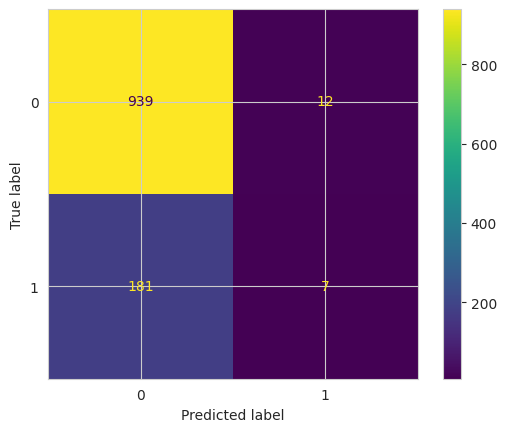

In [ ]:
model_evaluation_DT(x_train_DT,x_val_DT,y_train_DT,y_val_DT,10,cost_misclassification)

In [74]:
x_train_DT, x_test_DT, y_train_DT, y_test_DT = test_train_split_DT(X_cancer,Y_cancer,50,random_seed)
x_test_DT, x_val_DT, y_test_DT, y_val_DT = test_train_split_DT(X_cancer,Y_cancer,50,random_seed)

The accuracy is:  0.8333333333333334
The precision is:  0.9428571428571428
The recall is:  0.5546218487394958


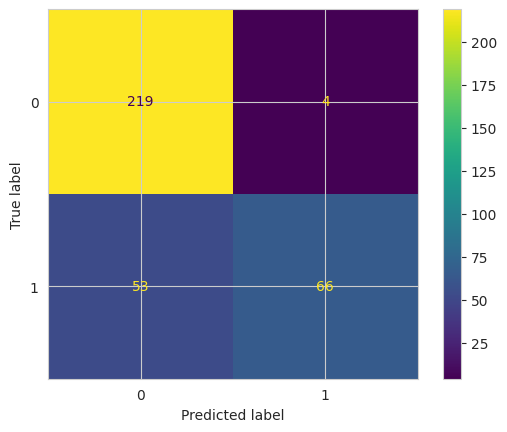

In [75]:
model_evaluation_DT(x_train_DT,x_val_DT,y_train_DT,y_val_DT,10,cost_misclassification)

K Cross Validation on DT

In [77]:
def k_fold_graph(k_values,dataset):
    from sklearn.metrics import accuracy_score
    import matplotlib.pyplot as plt
    import numpy as np

    tree = DecisionTree(max_depth=5)
    average_accuracies = []

    for k in k_values:
        accuracies = []

        # Perform k-fold cross-validation
        if dataset == 'Age':

          folds = k_fold_split_np_copy(X_age, Y_age, k, seed=random_seed)

        elif dataset == 'Cancer':

          folds = k_fold_split_np_copy(X_cancer, Y_cancer, k, seed=random_seed)

        for x_train_np, x_test_np, y_train_np, y_test_np in folds:
            # Create a new instance of the decision tree for each fold
            tree = DecisionTree(max_depth=5)

            # Fit the model on the training set for the current fold
            tree.fit(x_train_np, y_train_np)

            # Predict probabilities on the test set for the current fold
            probs_test_fold = tree.predict(x_test_np)

            # Evaluate accuracy for the current fold
            accuracy_fold = accuracy_score(y_test_np, np.argmax(probs_test_fold, axis=1))
            accuracies.append(accuracy_fold)

            print(f"Fold Accuracy: {accuracy_fold}")

        # Calculate the average accuracy over all folds for the current k
        average_accuracy = sum(accuracies) / len(accuracies)
        average_accuracies.append(average_accuracy)

    # Plot the average accuracies vs amount of folds
    plt.plot(k_values, average_accuracies, marker='o')
    plt.xlabel('Number of Folds (k)')
    plt.ylabel('Average Accuracy')
    plt.title('Average Accuracy vs Number of Folds')
    plt.show()

Fold Accuracy: 0.8402107111501317
Fold Accuracy: 0.8402107111501317
Fold Accuracy: 0.8407894736842105
Fold Accuracy: 0.8511198945981555
Fold Accuracy: 0.8287220026350461
Fold Accuracy: 0.8421052631578947
Fold Accuracy: 0.8385964912280702
Fold Accuracy: 0.8558875219683656
Fold Accuracy: 0.8242530755711776
Fold Accuracy: 0.8442982456140351
Fold Accuracy: 0.8442982456140351
Fold Accuracy: 0.8552631578947368
Fold Accuracy: 0.832967032967033
Fold Accuracy: 0.8241758241758241
Fold Accuracy: 0.8342105263157895
Fold Accuracy: 0.8473684210526315
Fold Accuracy: 0.8394736842105263
Fold Accuracy: 0.8631578947368421
Fold Accuracy: 0.8337730870712401
Fold Accuracy: 0.8232189973614775
Fold Accuracy: 0.8466257668711656
Fold Accuracy: 0.843558282208589
Fold Accuracy: 0.8343558282208589
Fold Accuracy: 0.8461538461538461
Fold Accuracy: 0.8615384615384616
Fold Accuracy: 0.8338461538461538
Fold Accuracy: 0.8153846153846154
Fold Accuracy: 0.8421052631578947
Fold Accuracy: 0.8421052631578947
Fold Accuracy: 0

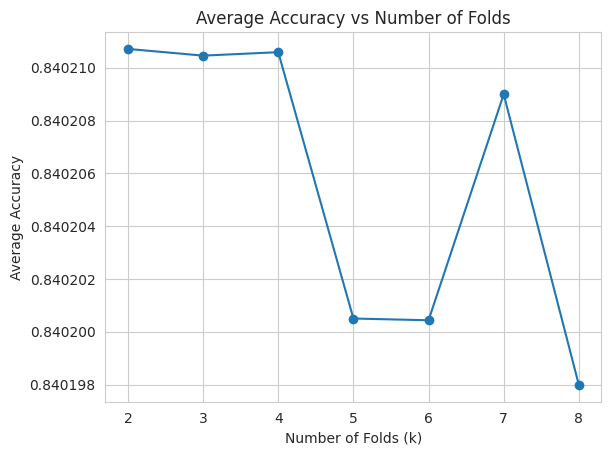

In [78]:
# Age Dataset
k_values = range(2, 9)
k_fold_graph(k_values,'Age')

Fold Accuracy: 0.6403508771929824
Fold Accuracy: 0.6598240469208211
Fold Accuracy: 0.6228070175438597
Fold Accuracy: 0.6666666666666666
Fold Accuracy: 0.6607929515418502
Fold Accuracy: 0.6491228070175439
Fold Accuracy: 0.631578947368421
Fold Accuracy: 0.6491228070175439
Fold Accuracy: 0.6705882352941176
Fold Accuracy: 0.6642335766423357
Fold Accuracy: 0.5912408759124088
Fold Accuracy: 0.6715328467153284
Fold Accuracy: 0.6470588235294118
Fold Accuracy: 0.6764705882352942
Fold Accuracy: 0.6754385964912281
Fold Accuracy: 0.5701754385964912
Fold Accuracy: 0.6754385964912281
Fold Accuracy: 0.6578947368421053
Fold Accuracy: 0.6666666666666666
Fold Accuracy: 0.6548672566371682
Fold Accuracy: 0.7040816326530612
Fold Accuracy: 0.5816326530612245
Fold Accuracy: 0.5918367346938775
Fold Accuracy: 0.673469387755102
Fold Accuracy: 0.6597938144329897
Fold Accuracy: 0.711340206185567
Fold Accuracy: 0.6288659793814433
Fold Accuracy: 0.7209302325581395
Fold Accuracy: 0.5813953488372093
Fold Accuracy: 0.

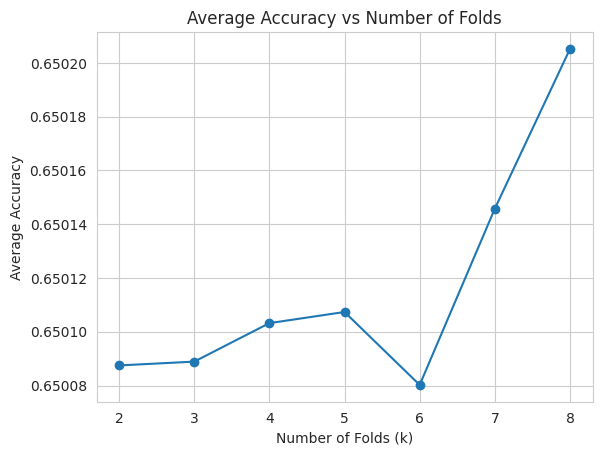

In [79]:
# Cancer Dataset
k_values = range(2, 9)
k_fold_graph(k_values,'Cancer')

How Max Tree Depth Affect the Performance of Decision Tree Models:

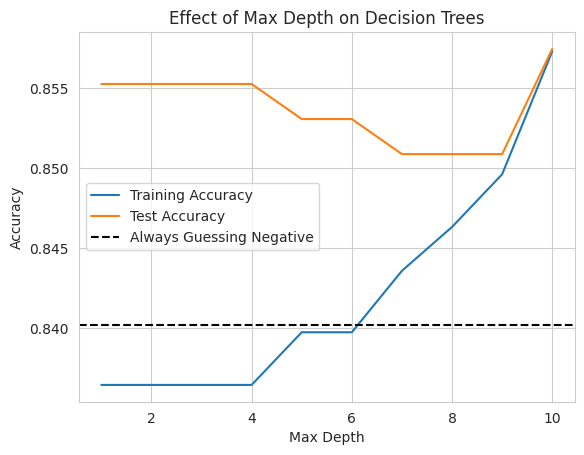

(Text(0.5, 24.0, 'Max Depth'),
 Text(24.0, 0.5, 'Accuracy'),
 Text(0.5, 1.0, 'Effect of Max Depth on Decision Trees'),
 None)

In [82]:
# Age Dataset
x_train_DT, x_test_DT, y_train_DT, y_test_DT = test_train_split_DT(X_age,Y_age,80,random_seed)
x, y, y_train_KNN, z = test_train_split_KNN(X_age,Y_age,80,random_seed)

max_depth_values = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
train_scores, test_scores = [], []


for depth in max_depth_values:

    tree = DecisionTree(max_depth=depth,cost_fn=cost_misclassification)
    tree.fit(x_train_DT, y_train_DT)

    y_pred_train = tree.predict(x_train_DT)
    y_pred_test = tree.predict(x_test_DT)

    train_scores.append(accuracy(y_pred_train, y_train_KNN))
    test_scores.append(accuracy(y_pred_test, y_test_DT))

plt.plot(max_depth_values, train_scores, label='Training Accuracy')
plt.plot(max_depth_values, test_scores, label='Test Accuracy')
random_chance = percentages(Y_age)
plt.axhline(y=random_chance[2], color='k', linestyle='--',label='Always Guessing Negative')
plt.xlabel('Max Depth'), plt.ylabel('Accuracy'), plt.title('Effect of Max Depth on Decision Trees'), plt.legend(), plt.show()

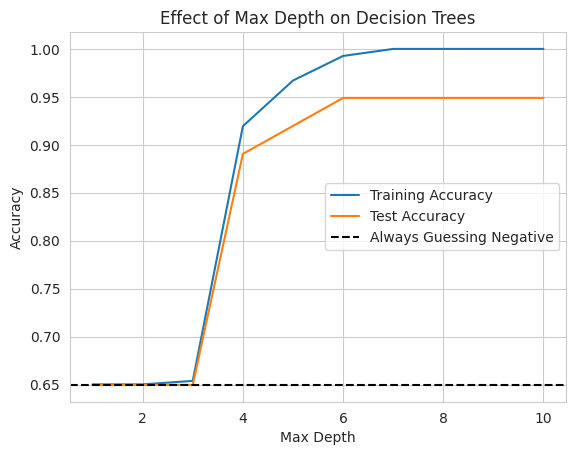

(Text(0.5, 24.0, 'Max Depth'),
 Text(24.000000000000007, 0.5, 'Accuracy'),
 Text(0.5, 1.0, 'Effect of Max Depth on Decision Trees'),
 None)

In [ ]:
# Cancer Dataset
x_train_DT, x_test_DT, y_train_DT, y_test_DT = test_train_split_DT(X_cancer,Y_cancer,80,random_seed)
x, y, y_train_KNN, z = test_train_split_KNN(X_cancer,Y_cancer,80,random_seed)

max_depth_values = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
train_scores, test_scores = [], []


for depth in max_depth_values:

    tree = DecisionTree(max_depth=depth,cost_fn=cost_gini_index)
    tree.fit(x_train_DT, y_train_DT)

    y_pred_train = tree.predict(x_train_DT)
    y_pred_test = tree.predict(x_test_DT)

    train_scores.append(accuracy(y_pred_train, y_train_KNN))
    test_scores.append(accuracy(y_pred_test, y_test_DT))

plt.plot(max_depth_values, train_scores, label='Training Accuracy')
plt.plot(max_depth_values, test_scores, label='Test Accuracy')
random_chance = percentages(Y_cancer)
plt.axhline(y=random_chance[2], color='k', linestyle='--',label='Always Guessing Negative')
plt.xlabel('Max Depth'), plt.ylabel('Accuracy'), plt.title('Effect of Max Depth on Decision Trees'), plt.legend(), plt.show()

Feature importance for DTs

In [ ]:
""" Gini Feature Importance """

def compute_feature_importance_GI_and_counts(tree):
    """
    Computes the feature importance based on the reduction of the Gini index and
    counts the number of non-leaf nodes each feature is used.
    """
    feature_importances = {}
    feature_counts = {}

    def gini(labels):
        _, counts = np.unique(labels, return_counts=True)
        probabilities = counts / counts.sum()
        return 1 - np.sum(probabilities**2)

    def traverse(node):
      if node is None:
          return

      if node.left is None and node.right is None:
          return

      gini_index = gini(node.labels[node.data_indices])
      left_gini = gini(node.left.labels[node.left.data_indices]) if node.left else 0
      right_gini = gini(node.right.labels[node.right.data_indices]) if node.right else 0
      left_split_count = len(node.left.data_indices) if node.left else 0
      right_split_count = len(node.right.data_indices) if node.right else 0
      total_count = left_split_count + right_split_count

      gini_reduction = gini_index - (left_split_count / total_count * left_gini) - (right_split_count / total_count * right_gini)

      if node.split_feature is not None:
        # Initialize the feature count if it doesn't exist
          if node.split_feature not in feature_counts:
              feature_counts[node.split_feature] = 0

        # Update feature importances with gini reduction
          if node.split_feature in feature_importances:
              feature_importances[node.split_feature]['importance'] += gini_reduction
          else:
              feature_importances[node.split_feature] = {'importance': gini_reduction, 'count': 0}

        # Increment the feature count
          feature_counts[node.split_feature] += 1

      traverse(node.left)
      traverse(node.right)

    traverse(tree.root)

    # Combine counts and importances
    combined_feature_info = {feature: {'importance': importance['importance'], 'count': feature_counts.get(feature, 0)}
                             for feature, importance in feature_importances.items()}

    return combined_feature_info

tree = DecisionTree(max_depth=5, cost_fn=cost_entropy)
x_train_DT, x_test_DT, y_train_DT, y_test_DT = test_train_split_DT(X_age,Y_age,50,random_seed)
# Fit the DecisionTree to the training data using the existing datasets
tree.fit(x_train_DT, y_train_DT)

# Import the compute_feature_importance_GI function here

# Now compute the feature importances using the fitted tree
feature_importance = compute_feature_importance_GI_and_counts(tree)
print("Feature importances:", feature_importance)

tree2 = DecisionTree(max_depth =5)
x_train, x_test, y_train, y_test = test_train_split_DT(X_cancer,Y_cancer,50,random_seed)
tree2.fit(x_train, y_train)
feat_importance = compute_feature_importance_GI_and_counts(tree2)
print("Feature importances:", feat_importance)

Feature importances: {5: {'importance': 0.059723977987338736, 'count': 4}, 6: {'importance': 0.157487139673811, 'count': 7}, 2: {'importance': 0.11281348172833812, 'count': 7}, 0: {'importance': 0.0, 'count': 4}, 1: {'importance': 0.011651416614679111, 'count': 5}, 3: {'importance': 0.09598175042178203, 'count': 4}}
Feature importances: {1: {'importance': 0.35093557827086275, 'count': 2}, 5: {'importance': 0.06641149137233425, 'count': 1}, 0: {'importance': 0.19144256501746737, 'count': 10}, 3: {'importance': 0.1975457234444074, 'count': 2}, 8: {'importance': 0.0012918255025187314, 'count': 1}, 2: {'importance': 0.0004079013544685678, 'count': 2}}


# AUROC of Decision Trees

Redoing Decision Tree Algorithm But With Custom Thresholds

Note that all code under this section must be ran sequentially for proper execution.

In [83]:
class Node:
    def __init__(self, data_indices, parent):
        self.data_indices = data_indices                    #stores the data indices which are in the region defined by this node
        self.left = None                                    #stores the left child of the node
        self.right = None                                   #stores the right child of the node
        self.split_feature = None                           #the feature for split at this node
        self.split_value = None                             #the value of the feature for split at this node
        if parent:
            self.depth = parent.depth + 1                   #obtain the dept of the node by adding one to dept of the parent
            self.num_classes = parent.num_classes           #copies the num classes from the parent
            self.data = parent.data                         #copies the data from the parent
            self.labels = parent.labels                     #copies the labels from the parent
            class_prob = np.bincount(self.labels[data_indices], minlength=self.num_classes) #this is counting frequency of different labels in the region defined by this node
            self.class_prob = class_prob / np.sum(class_prob)  #stores the class probability for the node
            #note that we'll use the class probabilites of the leaf nodes for making predictions after the tree is built

In [84]:
def greedy_test(node, cost_fn):
    #initialize the best parameter values
    best_cost = np.inf
    best_feature, best_value = None, None
    num_instances, num_features = node.data.shape
    #sort the features to get the test value candidates by taking the average of consecutive sorted feature values
    data_sorted = np.sort(node.data[node.data_indices],axis=0)
    test_candidates = (data_sorted[1:] + data_sorted[:-1]) / 2.
    for f in range(num_features):
        #stores the data corresponding to the f-th feature
        data_f = node.data[node.data_indices, f] ##this is the threshold value for splitting nodes
        for test in test_candidates[:,f]:
            #Split the indices using the test value of f-th feature
            left_indices = node.data_indices[data_f <= test]
            right_indices = node.data_indices[data_f > test]
            #we can't have a split where a child has zero element
            #if this is true over all the test features and their test values  then the function returns the best cost as infinity
            if len(left_indices) == 0 or len(right_indices) == 0:
                continue
            #compute the left and right cost based on the current split
            left_cost = cost_fn(node.labels[left_indices])
            right_cost = cost_fn(node.labels[right_indices])
            num_left, num_right = left_indices.shape[0], right_indices.shape[0]
            #get the combined cost using the weighted sum of left and right cost
            cost = (num_left * left_cost + num_right * right_cost)/num_instances
            #update only when a lower cost is encountered
            if cost < best_cost:
                best_cost = cost
                best_feature = f
                best_value = test
    return best_cost, best_feature, best_value

In [85]:
#computes misclassification cost by subtracting the maximum probability of any class
def cost_misclassification(labels):
    counts = np.bincount(labels)
    class_probs = counts / np.sum(counts)
    #print(class_probs)
    #you could compress both the steps above by doing class_probs = np.bincount(labels) / len(labels)
    return 1 - np.max(class_probs)

#computes entropy of the labels by computing the class probabilities
def cost_entropy(labels):
    class_probs = np.bincount(labels) / len(labels)
    class_probs = class_probs[class_probs > 0]              #this steps is remove 0 probabilities for removing numerical issues while computing log
    return -np.sum(class_probs * np.log2(class_probs))       #expression for entropy -\sigma p(x)log[p(x)]

#computes the gini index cost
def cost_gini_index(labels):
    class_probs = np.bincount(labels) / len(labels)
    return 1 - np.sum(np.square(class_probs))               #expression for gini index 1-\sigma p(x)^2

In [86]:
class DecisionTree:
    def __init__(self, num_classes=None, max_depth=3, cost_fn=cost_misclassification, min_leaf_instances=1):
        self.max_depth = max_depth      #maximum dept for termination
        self.root = None                #stores the root of the decision tree
        self.cost_fn = cost_fn          #stores the cost function of the decision tree
        self.num_classes = num_classes  #stores the total number of classes
        self.min_leaf_instances = min_leaf_instances  #minimum number of instances in a leaf for termination

    def fit(self, data, labels):
        pass                            #pass in python 3 means nothing happens and the method here is empty

    def predict(self, data_test):
        pass

In [87]:
def fit(self, data, labels, threshold):
    self.data = data
    self.labels = labels
    if self.num_classes is None:
        self.num_classes = 2
    #below are initialization of the root of the decision tree
    self.root = Node(np.arange(data.shape[0]), None)
    self.root.data = data
    self.root.labels = labels
    self.root.num_classes = self.num_classes
    self.root.depth = 0
    #to recursively build the rest of the tree
    self._fit_tree(self.root,threshold)
    return self

def _fit_tree(self, node,threshold):
    #This gives the condition for termination of the recursion resulting in a leaf node
    if node.depth == self.max_depth or len(node.data_indices) <= self.min_leaf_instances:
        return
    #greedily select the best test by minimizing the cost
    cost, split_feature, split_value = greedy_test(node, self.cost_fn)
    #if the cost returned is infinity it means that it is not possible to split the node and hence terminate
    if np.isinf(cost):
        return
    #print(f'best feature: {split_feature}, value {split_value}, cost {cost}')
    #to get a boolean array suggesting which data indices corresponding to this node are in the left of the split
    test = node.data[node.data_indices,split_feature] <= split_value
    #store the split feature and value of the node
    node.split_feature = split_feature
    node.split_value = threshold*2
    #define new nodes which are going to be the left and right child of the present node
    left = Node(node.data_indices[test], node)
    right = Node(node.data_indices[np.logical_not(test)], node)
    #recursive call to the _fit_tree()
    self._fit_tree(left,threshold*2)
    self._fit_tree(right,threshold*2)
    #assign the left and right child to present child
    node.left = left
    node.right = right

DecisionTree.fit = fit
DecisionTree._fit_tree = _fit_tree

In [88]:
def predict(self, data_test):
    class_probs = np.zeros((data_test.shape[0], 1))
    for n, x in enumerate(data_test):
        node = self.root
        #loop along the dept of the tree looking region where the present data sample fall in based on the split feature and value
        while node.left:
            if x[node.split_feature] <= node.split_value:
                node = node.left
            else:
                node = node.right
        #the loop terminates when you reach a leaf of the tree and the class probability of that node is taken for prediction
        class_probs[n] = int(node.class_prob[1])
    return pd.DataFrame(class_probs,columns=['Prediction'])

DecisionTree.predict = predict

AUROC of Decision Tree

In [89]:
def auroc_DT(x_train,x_test,y_train,y_test,best_tree_depth,cost,print_plot=True):
  """
  Function: Returns the AUROC score of model with the ROC graph
  Args:
  - x_train(np array): The randomized training attributes
  - x_test(np array): The randomized test attributes
  - y_train(np array): The randmized training labels
  - y_test(np array): The randomized testing labels
  - best_tree_depth(int): Optimized k value
  - cost(str): Distance/cost function of KNN
  - print_plot(bool): Show ROC plot or not
  Returns:
  - auc: The AUROC score of model
  """

  # Empty lists for plotting the ROC
  TPR_list = []
  FPR_list = []

  # Tests various thresholds for ROC
  for prob in [1.,0.7,0.5,0.1,-1.]:

    # Predicted labels based on training data
    tree = DecisionTree(max_depth=best_tree_depth,cost_fn=cost)
    tree.fit(x_train,y_train,prob)
    y_pred = tree.predict(x_test)

    # True and False Positive Rate
    TPR = recall(y_pred,y_test)
    FPR = false_positive_rate(y_pred,y_test)

    # Adding to lists for plotting
    TPR_list.append(TPR)
    FPR_list.append(FPR)

  # Plotting the ROC
  if print_plot:
    plt.plot(FPR_list,TPR_list,color='r')
    plt.title('Receiver Operating Characteristic')
    plt.xlabel('False Positive Rate')
    plt.ylabel("True Positive Rate")
    plt.xlim(0.)
    plt.ylim(0.)
    plt.fill_between(FPR_list,TPR_list,alpha=0.1,color='r')
    plt.show()

  # AUROC Metric
  auc = sklearn.metrics.auc(FPR_list,TPR_list)

  return auc

#r = auroc_DT(x_train_DT,x_test_DT,y_train_DT,y_test_DT,10,cost_entropy,print_plot=True)

#print(r)

# Comparing ROC of DTs and KNN

Note that all code from the previous section must be ran before this block of code for proper execution.

In [90]:
def plot_roc(FPR_list, TPR_list, label, color):
    plt.plot(FPR_list, TPR_list, label=label, color=color)
    plt.fill_between(FPR_list, TPR_list, alpha=0.1, color=color)

def calculate_auc(FPR_list, TPR_list):
    # Calculate AUC using the trapezoidal rule
    auc_value = sum((x - FPR_list[i - 1]) * (y + TPR_list[i - 1]) / 2 for i, (x, y) in enumerate(zip(FPR_list, TPR_list)) if i > 0)
    return auc_value

def compare_auroc(x_train_DT, x_test_DT, y_train_DT, y_test_DT, best_tree_depth, cost,
                  x_train_KNN, x_test_KNN, y_train_KNN, y_test_KNN, best_k, similarity):
    # AUROC for Decision Tree
    TPR_list_DT, FPR_list_DT = [], []
    for prob in [1., 0.7, 0.5, 0.1, -1.]:
        tree = DecisionTree(max_depth=best_tree_depth, cost_fn=cost)
        tree.fit(x_train_DT, y_train_DT, prob)
        y_pred_DT = tree.predict(x_test_DT)
        TPR_list_DT.append(recall(y_pred_DT, y_test_DT))
        FPR_list_DT.append(false_positive_rate(y_pred_DT, y_test_DT))

    # AUROC for KNN
    TPR_list_KNN, FPR_list_KNN = [], []
    for prob in [1, 0.7, 0.5, 0.1, -1]:
        y_pred_KNN = weighted_k_nearest_neighbors(x_train_KNN, y_train_KNN, x_test_KNN, best_k, prob, similarity_type=similarity)
        TPR_list_KNN.append(recall(y_pred_KNN, y_test_KNN))
        FPR_list_KNN.append(false_positive_rate(y_pred_KNN, y_test_KNN))

    # Plotting both ROCs
    plt.figure()
    auc_DT = calculate_auc(FPR_list_DT, TPR_list_DT)
    auc_KNN = calculate_auc(FPR_list_KNN, TPR_list_KNN)

    plot_roc(FPR_list_DT, TPR_list_DT, label=f'Decision Tree, AUROC: {auc_DT:.2f}', color='r')
    plot_roc(FPR_list_KNN, TPR_list_KNN, label=f'KNN, AUROC: {auc_KNN:.2f}', color='b')

    plt.title('Receiver Operating Characteristic')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.xlim(0.)
    plt.ylim(0.)
    plt.legend()
    plt.show()


In [93]:
x_train_DT, x_test_DT, y_train_DT, y_test_DT = test_train_split_DT(X_age,Y_age,80,random_seed)
x_train_KNN, x_test_KNN, y_train_KNN, y_test_KNN = test_train_split_KNN(X_age,Y_age,80,random_seed)

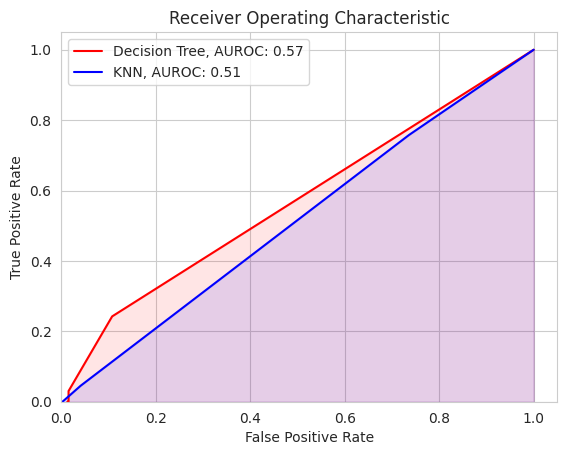

In [94]:
# Cancer Dataset
compare_auroc(x_train_DT, x_test_DT, y_train_DT, y_test_DT, 10, cost_entropy,
              x_train_KNN, x_test_KNN, y_train_KNN, y_test_KNN, 8, 'euclid')

In [91]:
x_train_DT, x_test_DT, y_train_DT, y_test_DT = test_train_split_DT(X_cancer,Y_cancer,80,random_seed)
x_train_KNN, x_test_KNN, y_train_KNN, y_test_KNN = test_train_split_KNN(X_cancer,Y_cancer,80,random_seed)

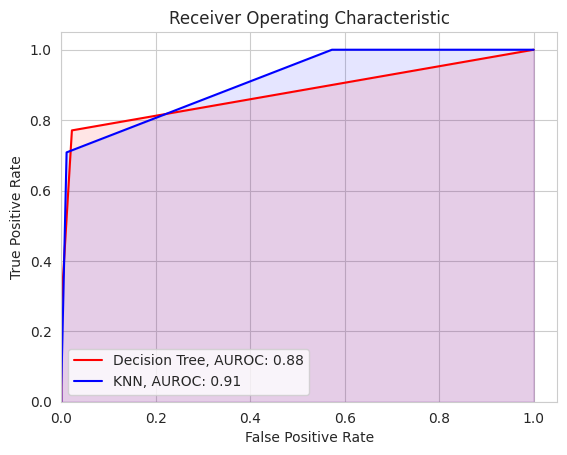

In [92]:
# Cancer Dataset
compare_auroc(x_train_DT, x_test_DT, y_train_DT, y_test_DT, 10, cost_gini_index,
              x_train_KNN, x_test_KNN, y_train_KNN, y_test_KNN, 18, 'euclid')